<a href="https://colab.research.google.com/github/vikxoxo/NLP/blob/master/Resturant_Chatbot_NoCustomAction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conversational Resturant Chat Bot with the Rasa stack
![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTaX3LNhGcAe1HnPZSuWS0oH6af0LJHXcH7If1sQgLCFAT1chNGFg)





*   Part 0: Setup workspace
*   Part 1: Teaching the chatbot to understand user inputs using Rasa NLU model
*   Part 2: Teaching the chatbot to handle multi-turn conversations using dialogue management model
*   Part 3: Chat with the bot


*   References:

    https://github.com/RasaHQ/rasa-workshop-pydata-berlin

    https://arxiv.org/abs/1712.05181


## Part 0: setup workspace

### Let's start with jupyter configuration

In [ ]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

####Install Rasa NLU and Rasa Core. You can jump this step if you have already installed it on your PC.

In [ ]:
import sys
python = sys.executable

# In your environment run:
!{python} -m pip install -U rasa_core==0.9.6 rasa_nlu[spacy]===0.12.3;

# as well as install a language model:
!{python} -m spacy download en_core_web_md
!{python} -m spacy link en_core_web_md en --force;

     |████████████████████████████████| 133kB 3.5MB/s 
     |████████████████████████████████| 133kB 10.4MB/s 
     |████████████████████████████████| 4.9MB 10.7MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 49.1MB 92kB/s 
     |████████████████████████████████| 665kB 47.2MB/s 
     |████████████████████████████████| 307kB 43.3MB/s 
     |████████████████████████████████| 440kB 42.8MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 81kB 10.2MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 5.3MB 44.4MB/s 
     |████████████████████████████████| 133kB 44.6MB/s 
     |████████████████████████████████| 122kB 48.6MB/s 
     |████████████████████████████████| 3.1MB 45.5MB/s 
     |████████████████████████████████| 204kB 50.5MB/s 
     |████████████████████████████████| 92kB 11.7MB/s 
    

In [ ]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("en")("Hello world!"))

rasa_nlu: 0.12.3 rasa_core: 0.9.6
Loading spaCy language model...
Hello world!


####Install some graph packages. You can jump this step if you have already installed it on your PC.

In [ ]:
!apt-get -qq install -y graphviz libgraphviz-dev pkg-config;
!breq install graphviz
!{python} -m pip install pygraphviz;

Selecting previously unselected package libxdot4.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../libxdot4_2.40.1-2_amd64.deb ...
Unpacking libxdot4 (2.40.1-2) ...
Selecting previously unselected package libgvc6-plugins-gtk.
Preparing to unpack .../libgvc6-plugins-gtk_2.40.1-2_amd64.deb ...
Unpacking libgvc6-plugins-gtk (2.40.1-2) ...
Selecting previously unselected package libgraphviz-dev.
Preparing to unpack .../libgraphviz-dev_2.40.1-2_amd64.deb ...
Unpacking libgraphviz-dev (2.40.1-2) ...
Setting up libxdot4 (2.40.1-2) ...
Setting up libgvc6-plugins-gtk (2.40.1-2) ...
Setting up libgraphviz-dev (2.40.1-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

/bin/bash: breq: command not found
     |████████████████████████████████| 122kB 3.2MB/s 
  Created wheel for p

## Part 1: Natural Language Understanding

Here some examples of the conversation with sentences from the user and exploited to build Rasa NLU model.  

**Conversation_1:**   
U: Hello  

B: Hello, how can I help you?  

U: I need to find best food in Muzaffarnagr 

B: These are some of the best resturants in Muzaffarnagar. Sangam Palace (Near Shiv Chowk), Nandi (New Mandi), Gokul (New Mandi), Radiant (Bhopa Road)

U: Yes, thanks

B: You're welcome
    
**Conversation_2:**  
U: Hey  

B: Hello, how can I help you?   

U: I need to find South Indian Food 

B: These are some resturants : Nandi (New Mandi), Sangam Palace (Near Shiv Chowk)

U: Thank you

B: You're welcome
  
**Conversation_3:**    
U: Heya  

B: Hello, how can I help you?   

U: I need to find resturants with medium budget.

B: These are some resturants with medium budget: Sangam Palace (Near Shiv Chowk), Dwarika (New Mandi), Good Life (Gandhi Colony), 7-11 (New Mandi)

U: Great

B: You're welcome  
 


### Creating the training data for language understanding model

In this step is originated a train set grouping user inputs into intents and highlighting key word by entities with its synonyms (entity values).  

In [ ]:
nlu_md = """
## intent:affirm
- yes
- of course
- sure
- yeah
- ok
- cool
- go for it
- yep
- yep, will do thank you
- I'm sure I will!
- oh awesome!
- Yes
- accept
- I accept
- i accept
- ok i accept
- I changed my mind. I want to accept it
- ok cool
- alright
- i will!
- ok, I behave now
- yop
- oki doki
- yes please
- yes please!
- jo
- yep if i have to
- amayzing
- confirm
- nice
- coolio
- definitely yes without a doubt
- yas
- yup
- perfect
- sure thing
- absolutely
- Oh, ok
- Sure
- hm, i'd like that
- ja
- sure!
- yes i accept
- Sweet
- amazing!
- how nice!
- cool!
- yay
- yes accept please
- great
- oh cool
- yes
- fine
- i will take that
- that sounds just right

## intent:bye
- goodbye
- goodnight
- good bye
- good night
- see ya
- toodle-oo
- bye bye
- gotta go
- farewell
- catch you later
- bye for now
- bye
- bye was nice talking to you
- bye udo
- bye bye bot
- bye bot
- k byyye #slay
- tlak to you later
- ciao
- Bye bye
- then bye
- tschüssikowski
- bye!

## intent:deny
- no
- nope
- definitely not
- never
- absolutely not
- i don't think so
- i'm afraid not
- no sir
- no ma'am
- no way
- no sorry
- No, not really.
- nah not for me
- nah
- no and no again
- no go
- no thanks
- decline
- deny
- i decline
- never mind
- nevermind
- I'm not giving you my email address
- no I haven't decided yet if I want to sign up
- I don't want to give it to you
- I'm not going to give it to you
- no i don't accept
- no!!!!
- no you did it wrong
- no i can't
- i'm not sure
- NEIN
- nein
- not really
- i guess it means - no
- i don't want to
- i don't want either of those
- nah thanks
- neither of these
- i don't like that option
- neither will work
- suggest some other option
- is this the best you can do

## intent:greet
- Hi
- Hey
- Hi bot
- Hey bot
- Hello
- Good morning
- hi again
- hi folks
- hi Mister
- hi pal!
- hi there
- greetings
- hello everybody
- hello is anybody there
- hello robot
- hallo
- heeey
- hi hi
- hey
- hey hey
- hello there
- hi
- hello
- yo
- hola
- hi?
- hey bot!
- hello friend
- good morning
- hii
- hello sweet boy
- yoo
- hey there
- hiihihi
- hello sweatheart
- hellooo
- helloooo
- heyo
- ayyyy whaddup
- hello?
- Hallo
- heya
- hey bot
- howdy
- Hellllooooooo
- whats up
- Hei
- Well hello there ;)
- I said, helllllloooooO!!!!
- Heya
- Whats up my bot
- hiii
- heyho
- hey, let's talk
- hey let's talk
- jojojo
- hey dude
- hello it is me again
- what up
- hi there
- hi
- jop
- hi friend
- hi there it's me
- good evening
- good morning
- good afternoon

## intent:out_of_scope
- I want pizza
- please help with my ice cream it's dripping
- no wait go back i want a dripping ice cream but a cone that catches it so you can drink the ice cream later
- i want a non dripping ice cream
- hey little mama let em whisper in your ear
- someone call the police i think the bot died
- show me a picture of a chicken
- neither
- I want french cuisine
- i am hungry
- restaurants
- restaurant
- you're a loser lmao
- can i be shown a gluten free restaurant
- i don't care!!!!
- i do not care how are you
- again?
- oh wait i gave you my work email address can i change it?
- hang on let me find it
- stop it, i do not care!!!
- really? you're so touchy?
- how come?
- I changed my mind
- what?
- did i break you
- I don't wanna tell the name of my company
- that link doesn't work!
- you already have that
- this is a really frustrating experience
- no stop
- i want a french restaurant
- shit bot
- do you want to marry me?
- give me food
- i want food
- udo, I want to marry you
- i wanna party
- shitmuncher
- I like you
- i want pizza
- i want pizza!!
- silly bot
- i want to eat
- you are a stupid bot
- i hate you
- Can I ask you questions first?
- is it a wasteland full of broken robot parts?
- i can't deal with _your_ request
- are you vegan
- who will anser my email?
- do you sell vacuum robots?
- i want to buy a roomba for my grandson
- and make chicken noises into the phone
- is barbara still married to you
- what's your wife doing this weekend
- how are the kids
- you're rather dull
- personal or work?
- are you using Rasa Core and NLU ?
- tell me a joke
- what else?
- I already told you! I'm a shitmuncher
- I'm a shitmuncher
- who are the engineers at rasa?
- who are they?
- can we keep chatting?
- talk to me
- who is your favourite robot?
- a tamed mouse will arrive at your doorstep in the next couple of days
- you will know it from the single red rose it carries between its teeth
- i will tame a mouse for you
- isn't the newsletter just spam?
- go back
- can you help me with the docs?
- sorry, i cannot rephrase
- and your REST API doesn't work
- i told you already
- better than you
- oh my god, not again!
- you are a badass bot!
- lol
- why do you need that?
- is that any of your business
- can you help me with your docs?
- i immediately need help with implementing the coolest bot you can imagine
- can you help me with your docs
- can you tell me how to build a bot?
- can you learn from our conversation?
- common, just try
- hey, I contacted you a couple of days ago but didn't get any response, any news?
- please hurry, i have deadline in two weeks to deliver the bot it is for very big company
- you are annoying
- Do I have to accept?
- Is Rasa really smart?
- kannst du auch deutsch?
- are the newsletter worth the subscription?
- it's a pity
- i want more of you in my life!
- the one that is better than you
- you suck
- bots are bad
- i dont like bots
- do you have a phone number?
- where do you live?
- how are akela's cats doing?
- but I just told you that :(
- Why don’t you answer?
- But you're an english site :(
- can you help me to build a bot

## intent:thank
- Thanks
- Thank you
- Thank you so much
- Thanks bot
- Thanks for that
- cheers
- cheers bro
- ok thanks!
- perfect thank you
- thanks a bunch for everything
- thanks for the help
- thanks a lot
- amazing, thanks
- cool, thanks
- cool thank you
- thanks
- thanks!
- Cool. Thanks
- thanks
- thanks this is great news
- thank you
- great thanks
- Thanks!
- cool thanks
- thanks for forum link, I'll check it out
- thanks!

## intent:ask_budget
 - I want to eat at a place between 300 and 700
 - I am fine with an expensive place
 - I am looking for a dinner place at less than 300

## intent:feedback
  -This hotel is not good.
  -I will give 4 star to this hotel
  -The food was bad
  -The place was dirty
  -The service was bad
  -3 star
  -2 
  -1
  -four
  -five
  -1 star
  -2 star
  -4 star
  -5 star
  -3
  -4
  -5
  -one
  -two
  -three
  -the food was excellent
  -the ambience was nice
  -I liked everything
  -I loved the place
  -it was children family
  -great
  -bad
  -loved it
  -never going again

## intent:feed_resturantName
-[Sangam Palace](resturant)
-[Nandi](resturant)
-[Gokul](resturant)
-[Radiant](resturant)
-[Dwarika](resturant)
-[Good Life](resturant)
-[7-11](resturant)
-[sangamplace](resturant)
-[nandi](resturant)
-[gokul](resturant)
-[radiant](resturant)
-[dwarika](resturant)
-[good life](resturant)
-[Sangam Palace](resturant)
-[Nandi](resturant)
-[Gokul](resturant)
-[Radiant](resturant)
-[Dwarika](resturant)
-[Good Life](resturant)
-[7-11](resturant)
-[sangamplace](resturant)
-[nandi](resturant)
-[gokul](resturant)
-[radiant](resturant)
-[dwarika](resturant)
-[good life](resturant)
-[Sangam Palace](resturant)
-[Nandi](resturant)
-[Gokul](resturant)
-[Radiant](resturant)
-[Dwarika](resturant)
-[Good Life](resturant)
-[7-11](resturant)
-[sangamplace](resturant)
-[nandi](resturant)
-[gokul](resturant)
-[radiant](resturant)
-[dwarika](resturant)
-[good life](resturant)
-[Sangam Palace](resturant)
-[Nandi](resturant)
-[Gokul](resturant)
-[Radiant](resturant)
-[Dwarika](resturant)
-[Good Life](resturant)
-[7-11](resturant)
-[sangamplace](resturant)
-[nandi](resturant)
-[gokul](resturant)
-[radiant](resturant)
-[dwarika](resturant)
-[good life](resturant)






## intent:ask_restaurant
<!-- only 'location' entity : 58 training samples-->
- Find me a place to eat in [Muzaffarnagar](location)
- Find me a place to eat in [New Mandi](location)
- Find me a place to eat in [City-Area](location)
- Find me a place to eat in [Out of City-Area](location)
- Find me a place to eat in [Bangalore](location)
- I need a new restaurant in [Bengaluru](location)
- [Bhopal](location)
- help me find restaurant in [Bngalore](location)
- Could you find me a restaurant to eat at [bngalore](location)?
- [Bhubaneshwar](location)
- Can you find me a restaurant in [Bombay](location)?
- [Amritsar](location)
- [erode](location)
- [Jammu](location)
- [Kurnool](location)
- Hey, help me find a restaurant in [Mumbai](location)
- I need to find a restaurant in [Kolkata](location)
- [Pune](location)
- [Cyberabad](location)
- [calcuta](location)
- Find a restaurant for me in [Calcutta](location)
- Where should I eat in [Delhi](location)?
- [Delhi NCR](location)
- Suggest me a good restaurant around [New Delhi](location)
- [Bengaluru](location)
- [Amratsar](location)
- I need to find this restaurant in [Delhi](location)
- [Dilli](location)
- Show me the closest open restaurant in [Chennai](location)
- [Indore](location)
- [Jodhpur](location)
- Hey help me find a restaurant in [Madras](location)
- Help me find a restaurant in [Surat](location)
- Recommend me a restaurant around [Pune](location)
- [Goa](location)
- Could you find a restaurant for me in [Belgaum](location)? 
- [Chandigarh](location)
- [Rajahmundry](location)
- [Ujjain](location)
- Could you find a restaurant for me in [Bengaluru](location)? 
- Would you find me a restaurant in [Allahabad](location)??
- [vadodara](location)
- [Srinagar](location)
- Could you find me a restaurant in [Agra](location)? 
- Pick a restaurant for me, please in [Kochi](location)
- [Mysuru](location)
- How can you help me find a restaurant in [Jamshedpur](location)?
- [Thrissur](location)
- Can you find a restaurant for me in [Chandigarh](location)?
- [Lucknow](location)
- Would you find me a restaurant in [Visakhapatnam](location)??
- Could you find me a restaurant to eat at [Gurgaon](location)?
- [NewDelhi](location)
- [Surat](location)
- [Jamshedpur](location)
- Would you find me a restaurant in [calcutta](location)??
- Okay. Show me some in [bengaluru](location)
- Recommend me a restaurant around [Prayagraj](location)
- [Rourkela](location)
- [Vijayawada](location)
- [Ajmer](location)
- [Allahabad](location)
- [raurkela](location)
- Can you suggest some good restaurants in [bombay](location)
<!-- only 'cuisine' entity : 26 training samples -->
- I'm gonna need help finding a [indian](cuisine) restaurant
- [american](cuisine)
- i'm looking for a [Chinese](cuisine) restaurant
- Hey, can you help me with locating a [mexican](cuisine) restaurant
- i want a [french](cuisine) restaurant
- [chinese](cuisine)
- What's a good place to eat [mexican](cuisine) food
- Find a restaurant for me where I can eat [north indian](cuisine)
- Find a restaurant for me to eat [mexican](cuisine)
- [italian](cuisine)
- I am hungry, find me some place to go eat [italian](cuisine)
- Would you find a [south indian](cuisine) restaurant for me?
- Would you find a [american](cuisine) restaurant
- [north indian](cuisine)
- A place to eat [chinase](cuisine)
- I want to eat [italian](cuisine) food
- Please find me a [south-indian](cuisine) restaurant
- [south indian](cuisine)
- Quickly get me a [northindian](cuisine) place
- Where can i get [south-indina](cuisine) food?
- I need to find a restaurant [southindian](cuisine)
- [mexican](cuisine)
- A place to have [italian](cuisine) food
- Suggest me a good [mexican](cuisine) restaurant
- how can you help me find a [french](cuisine) restaurant?
- [italian](cuisine)
<!-- location + cuisine entities : 22 training samples -->
- I'm gonna need help finding a [indian](cuisine) restaurant in [Mysore](location)
- i'm looking for a [Chinese](cuisine) restaurant in [Lucknow](location)
- Hey, can you help me with locating a [mexican](cuisine) restaurant in [Lakhanpur](location)
- i want a [french](cuisine) restaurant in [Vizag](location)
- What's a good place to eat [mexican](cuisine) food in [Bangalore](location)
- Find a restaurant for me where I can eat [north indian](cuisine) in [Jaipur](location)
- Find a restaurant for me to eat [mexican](cuisine) at [Faridabad](location)
- I am hungry, find me some place to go eat [italian](cuisine) in [Goa](location)
- Would you find a [south indian](cuisine) restaurant for me in [Kozhikode](location)?
- Would you find a [american](cuisine) restaurant for me in [Trivandrum](location)?
- A place to eat [chinase](cuisine) in [Mysuru](location)
- Hey, can you help me with locating a [north indian](cuisine) restaurant in [calcuta](location)
- I want to eat [italian](cuisine) food in [cochin](location)
- Please find me a [south-indian](cuisine) restaurant in [madras](location)
- Quickly get me a [northindian](cuisine) place in [New Delhi](location)
- Where can i get [south-indina](cuisine) food in [Mangaluru](location)
- i'm looking for a [Chinese](cuisine) restaurant in [cyberabad](location)
- [chinese](cuisine) eating place in [mumbai](location)
- I want to eat [italian](cuisine) food in [Prayagraj](location)
- Okay. I want to eat [south indian](cuisine) in [allahabad](location)
- Okay. Show me some [north indian](cuisine) restaurants in [prayagraj](location)
- What's a good place to eat [mexican](cuisine) food in [chandighar](location)
<!-- no entity : 22 training samples -->
- I need to find a restaurant
- Can you find me a good restaurant?
- Would you be able to search a place to eat?
- A place to have food
- Feeling hungry, can you help
- I am hungry, find a restaurant
- Get me some food quickly
- Pick some place for me to eat quickly
- Where can i get some food to eat
- i'm looking for a restaurant
- how can you help me find a restaurant
- pick a restaurant for me
- please find a restaurant for me
- I'm hungry. Looking out for some good restaurants
- I want to eat
- I am feeling hungry
- I need a new restaurant
- Suggest me a good restaurant
- where should i eat?
- I'm gonna need help finding a restaurant
- Show me an open restaurant
- Find a restaurant for me to eat
- I need to find a restaurant
- Can you find me a good restaurant?
- Would you be able to search a place to eat?
- A place to have food
- Feeling hungry, can you help
- I am hungry, find a restaurant
- Get me some food quickly
- Pick some place for me to eat quickly
- Where can i get some food to eat
- i'm looking for a restaurant
- how can you help me find a restaurant
- pick a restaurant for me
- please find a restaurant for me
- I'm hungry. Looking out for some good restaurants
- I want to eat
- I am feeling hungry
- I need a new restaurant
- Suggest me a good restaurant
- where should i eat?
- I'm gonna need help finding a restaurant
- Show me an open restaurant
- Find a restaurant for me to eat

## lookup:location
<!-- tier 1 cities -->
- Bangalore
- Chennai
- Delhi
- Hyderabad
- Kolkata
- Mumbai
<!-- tier 2 cities -->
- Agra 
- Ajmer 
- Aligarh
- Allahabad
- Amravati 
- Amritsar 
- Asansol 
- Ahmedabad 
- Bareilly 
- Belgaum 
- Bhavnagar 
- Bhiwandi 
- Bhopal 
- Bhubaneswar 
- Bikaner 
- Chandigarh 
- Coimbatore 
- Nagpur 
- Cuttack 
- Dehradun 
- Dhanbad 
- Durgapur 
- Erode 
- Faridabad 
- Firozabad 
- Gulbarga 
- Guntur 
- Gwalior 
- Gurgaon 
- Guwahati 
- Indore 
- Jabalpur 
- Jaipur 
- Jalandhar 
- Jammu 
- Jamnagar 
- Jamshedpur 
- Jhansi 
- Jodhpur 
- Kakinada 
- Kannur 
- Kanpur 
- Kochi 
- Kottayam 
- Kolhapur 
- Kollam 
- Kozhikode 
- Kurnool 
- Lucknow
- Ludhiana 
- Madurai 
- Malappuram 
- Mathura 
- Goa 
- Mangalore 
- Meerut 
- Muzaffarnagar
- New Mandi
- City-Area
- Out of City-Area
- Moradabad 
- Mysore 
- Nanded 
- Nashik 
- Nellore 
- Noida 
- Palakkad 
- Patna 
- Pondicherry 
- Pune 
- Raipur 
- Rajkot 
- Rajahmundry 
- Ranchi 
- Rourkela 
- Sangli 
- Siliguri 
- Solapur 
- Srinagar 
- Surat 
- Thiruvananthapuram 
- Thrissur 
- Tiruchirappalli 
- Tirunelveli 
- Tiruppur 
- Tiruvannamalai 
- Ujjain 
- Bijapur 
- Vadodara 
- Varanasi 
- Vijayawada 
- Visakhapatnam 
- Vellore 
- Warangal

## lookup:cuisine
- american
- chinese
- italian
- mexican
- north indian
- south indian

## lookup:resturant
- sangam palace
- Sangam Palace
- Nandi
- Gokul
- Radiant
- Dwarika
- 7-11
- Goodlife
- Ganpati
- Maa Jagdamba
- Green apple
- omega
- Marvadi
- Italian Bite
- silverspoon

## synonym:Sangam Palace
- sangam palace
- sangamplace
- samgam
- sangam place

## synonym:Nandi
- nandi
- nndi
- nanndi

## synonym:7-11
- seven eleven
- seveneleven


## synonym:Goodlife
- good life
- gud life
- goodlife

## synonym:Italian Bite
- italian bite
- italianbite
- Italian Bite

## synonym:silverspoon
- silver spoon
- Silverspoon
- Silver Spoon


## synonym:chinese
- Chinese
- Chinase

## synonym:south indian
- south-indian
- southindian
- south-indina
- South Indian

## synonym:north indian
- north-indian
- northindian
- north-indina
- North Indian

## synonym:Bengaluru
- Bangalore
- bngalore
- bengalluru
- Bangalor
- bangalore
- bengaluru

## synonym:Delhi NCR
- New Delhi
- Delhi
- NewDelhi
- Dilli
- Dellhi
- newdelhi
- Newdelhi
- new delhi
- new Delhi

## synonym:Mumbai
- Bombay
- mumbai
- bombay

## synonym:Kolkata
- Calcutta
- kolkata
- kolkatta
- calcutta
- calcuta

## synonym:Chennai
- chennai
- madras
- Madras

## synonym:Hyderabad
- hyderabad
- Secunderabad
- secunderabad
- cyberabad
- Cyberabad

## synonym:Lucknow
- Lakhanpur

## synonym:Mysore
- mysore
- mysuru
- Mysuru

## synonym Kochi
- kochi
- cochin
- Cochin

## synonym:Mangalore
- mangalore
- mangaluru
- Mangaluru

## synonym:Visakhapatnam
- visakhapatnam
- Vizag
- vizag

## synonym:Thiruvananthapuram
- thiruvananthapuram
- trivandrum
- Trivandrum
- Travancore
- travancore

## synonym:Vadodara
- vadodara
- Vadodra
- vadodra

## synonym:Jamshedpur
- jamshedpur
- Jamsedpur
- jamsedpur

## synonym:Rajahmundry
- rajahmundry
- Rajahmundri
- rajahmundri
- Rajamundry
- rajamundry
- Rajamundri
- rajamundri

## synonym:Rourkela
- rourkela
- Raurkela
- raurkela

## synonym:Amritsar
- amritsar
- Amratsar
- amratsar

## synonym:Chandigarh
- chandigarh
- Chandighar
- chandighar

## synonym:Allahabad
- prayagraj
- Prayagraj
- Allahabad
- allahabad

## synonym:Nashik
- nashik
- Nasik
- nasik

## synonym:Pondicherry
- pondicherry
- puducherry
- Puducherry

## synonym:Muzaffarnagar
- muzaffar nagar
- muzafarnagar
- near me
- in my neigbourhood
- in my locality
- in my city

## synonym:New Mandi
- newmandi
- new mandi
- new-mandi
- kukda-mandi
- patel nagar
- shivpuri
- gandhinagar
- adarsh colony
- gandhi colony
- ramvihar
- laxman vihar
- agrasen-vihar
- bhartiya colony

## synonym:City-Area
- city area
- cityarea
- saket colony
- bharmpury
- keshavpuri
-jat colony
-reshu vihar
-sikshak colony


## synonym:Out of City-Area
-out of city
-in isolation
-on highway
-private
-merrut highway


<!-- markdownlint-restore -->
"""

%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


### Defining the NLU model

With the training dataset is possible to build the NLU model by a pipeline which defines how structured data is extracted from unstructured user inputs. 

In [ ]:
config = """
language: "en"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_crf"                     # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
- name: "ner_synonyms"                # trains the synonyms
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


### Training the Rasa NLU Model

Let's start training the dataset with user inputs.

In [ ]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 684 (10 distinct intents)
	- Found intents: 'greet', 'feed_resturantName', 'ask_restaurant', 'ask_budget', 'thank', 'out_of_scope', 'deny', 'feedback', 'affirm', 'bye'
	- entity examples: 164 (3 distinct entities)
	- found entities: 'location', 'cuisine', 'resturant'

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_crf
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_spacy
INFO:rasa_nlu.model:

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.6s finished
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_synonyms
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Successfully saved model into '/content/models/nlu/default/current'


### Using & evaluating the NLU model

Have a look on how the model is performing on a sentence:

In [ ]:
pprint(interpreter.parse("I want a chinese resturant in Muzaffarnagar"))

{
  "intent": {
    "name": "ask_restaurant",
    "confidence": 0.8248658008416948
  },
  "entities": [
    {
      "start": 9,
      "end": 16,
      "value": "chinese",
      "entity": "cuisine",
      "confidence": 0.6779173627868611,
      "extractor": "ner_crf",
      "processors": [
        "ner_synonyms"
      ]
    },
    {
      "start": 30,
      "end": 43,
      "value": "muzaffarnagar",
      "entity": "location",
      "confidence": 0.9883461560813086,
      "extractor": "ner_crf"
    }
  ],
  "intent_ranking": [
    {
      "name": "ask_restaurant",
      "confidence": 0.8248658008416948
    },
    {
      "name": "out_of_scope",
      "confidence": 0.15816096637790503
    },
    {
      "name": "affirm",
      "confidence": 0.003450979906643897
    },
    {
      "name": "feedback",
      "confidence": 0.003269430970030756
    },
    {
      "name": "ask_budget",
      "confidence": 0.0026493199545887048
    },
    {
      "name": "bye",
      "confidence": 0.00238058818

Evaluation of a standalone model using all the dataset without a split train-test for semplicity. Upgraded version afford the split train-test option.

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 684 (10 distinct intents)
	- Found intents: 'greet', 'feed_resturantName', 'ask_restaurant', 'ask_budget', 'thank', 'out_of_scope', 'deny', 'feedback', 'affirm', 'bye'
	- entity examples: 164 (3 distinct entities)
	- found entities: 'location', 'cuisine', 'resturant'

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 684 examples that have a defined intent out of 684 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.9429349536659669
INFO:rasa_nlu.evaluate:Precision: 0.9522073770324442
INFO:rasa_nlu.evaluate:Accuracy:  0.9415204678362573
INFO:rasa_nlu.evaluate:Classification report: 
                    precision    recall  f1-score   support

            affirm       0.98      0.95      0.96

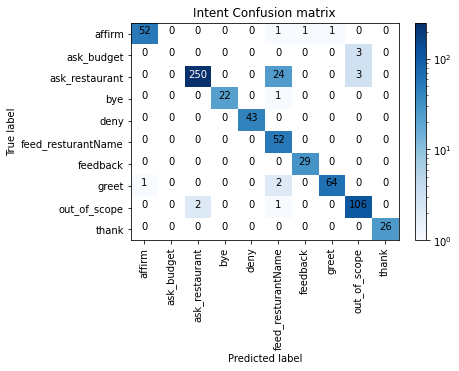

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_crf 
INFO:rasa_nlu.evaluate:F1-Score:  0.9739954289762888
INFO:rasa_nlu.evaluate:Precision: 0.9763043310493842
INFO:rasa_nlu.evaluate:Accuracy:  0.9755902360944377
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

    cuisine       0.92      0.88      0.90        65
   location       1.00      0.61      0.76        96
  no_entity       0.98      0.99      0.99      2266
  resturant       0.87      1.00      0.93        72

avg / total       0.98      0.98      0.97      2499



In [ ]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("nlu.md", model_directory)


# Part 2: Handling the dialogue

In this part at the chatbot is taught how to make responses by training a dialogue management model with Rasa Core.

### Writing Stories

The dataset used for dialogue management models are represented by 'stories': actual conversations. User inputs expressed by intents, entities and value entities, start with '*'. Chatbot responses expressed as actions, start with '-'. 

In [ ]:
stories_md = """
<!-- markdownlint-disable -->

<!-- greet, ask restaurant -->
## story_01_location_cuisine_valid_feedback
* greet
  - utter_greet
* ask_restaurant
  - utter_ask_location
* ask_restaurant{"location": "Muzaffarnagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Indian"}
  - utter_ask_budget
* ask_budget{"budget": "299"}
  - utter_ask_details
* affirm
  - utter_all_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

## story_02_location_invalid_feedback
* greet
  - utter_greet
* ask_restaurant
  - utter_ask_location
* ask_restaurant{"location": "Bangalore"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Muzaffarnagar"}
  - utter_ask_cuisine  
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "299"}
  - utter_ask_details
* affirm
  - utter_chinese_list
* thank
  - utter_bye

## story_03_location_invalid
* greet
  - utter_greet
* ask_restaurant
  - utter_ask_location
* ask_restaurant{"location": "Bangalore"}
  - utter_location_invalid
  - utter_ask_location_retry
* deny
  - utter_deny
  - utter_bye

## story_04_location_cuisine_valid_feedback
* greet
  - utter_greet
* ask_restaurant
  - utter_ask_location
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "North Indian"}
  - utter_ask_budget
* ask_budget{"budget": "299"}
  - utter_ask_details
* deny
  - utter_did_that_help
* affirm
  - utter_all_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

## story_05_location_out_of_scope_affirm  
* greet
  - utter_greet
* ask_restaurant
  - utter_ask_location
* out_of_scope
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_cuisine  
* ask_restaurant{"cuisine": "Chinese"} 
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_chinese_list
* thank
  - utter_bye

## story_06_location_out_of_scope_deny
* greet
  - utter_greet
* ask_restaurant
  - utter_ask_location
* out_of_scope
  - utter_location_invalid
  - utter_ask_location_retry
* deny
  - utter_deny
  - utter_bye


<!-- greet, location + cuisine-->
## story_07_location_cuisine_budget_valid_feedback
* greet
  - utter_greet
* ask_restaurant{"location": "Mumbai", "cuisine": "american"}
  - utter_ask_budget
* ask_budget{"budget": "701"}
  - utter_ask_details
* affirm
  - utter_american_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye 

## story_08_location_cuisine_budget_valid_feedback
* greet
  - utter_greet
* ask_restaurant{"location": "Muzaffarnagar", "cuisine": "South Indian"}
  - utter_ask_budget
* ask_budget{"budget": "300"} 
  - utter_ask_details
* affirm
  - utter_south_list
  - utter_taken_help
* deny
  - utter_did_that_help
* affirm
  - utter_happy
  - utter_bye


## story_09_location_cuisine_invalid_feedback
* greet
  - utter_greet
* ask_restaurant{"location": "Mumbai", "cuisine": "chinese"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "701"}
  - utter_ask_details
* affirm
  - utter_chinese_list
* thank
  - utter_bye

## story_10_location_cuisine_invalid_feedback
* greet
  - utter_greet
* ask_restaurant{"location": "agra", "cuisine": "italian"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* affirm
  - utter_happy
  - utter_bye

## story_11_cuisine_invalid_retry_deny
* greet
  - utter_greet
* ask_restaurant{"location": "agra", "cuisine": "italian"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* deny
  - utter_deny
  - utter_bye

<!-- no greet, location + cuisine -->
## story_12_no_greet_location_cuisine_budget_valid_feedback
* ask_restaurant{"cuisine":"indian","location":"Mysore"}
  - utter_ask_budget
* ask_budget{"budget":"701"}
  - utter_ask_details
* deny
  - utter_deny
* affirm
  - utter_chinese_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye
  

## story_13_no_greet_location_cuisine_budget_valid_feedback
* ask_restaurant{"cuisine":"indian","location":"Muzaffar nagar"}
  - utter_ask_budget
* ask_budget{"budget":"701"}
  - utter_ask_details
* affirm
  - utter_chinese_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

## story_14_no_greet_location_cuisine_invalid_retry_no_email
* ask_restaurant{"cuisine":"indian","location":"Mysore"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget":"701"}
  - utter_ask_details
* deny
  - utter_deny
  - utter_bye


## story_15_no_greet_location_cuisine_invalid_retry_deny
* ask_restaurant{"cuisine":"indian","location":"Mysore"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* deny
  - utter_deny
  - utter_bye


## story_16_no_greet_location_cuisine_invalid_retry_with_email
* ask_restaurant{"cuisine":"indian","location":"Mysore"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget":"701"}
  - utter_chinese_list
* affirm
  - utter_bye


<!-- queries with cuisine only -->

<!-- start with greet, followed by question -->
## story_17_greet_cuisine_valid_email
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_chinese_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_18_greet_cuisine_valid
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_chinese_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_19_greet_cuisine_invalid_retry_no_email
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "All list"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_all_list
* deny
  - utter_did_that_help
* affirm
  - utter_happy
  - utter_bye

## story_20_greet_cuisine_invalid_retry_email
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_chinese_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* thank
  - utter_bye


## story_21_greet_cuisine_valid_location_invalid
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_best_list
* thank
  - utter_bye

## story_22_greet_cuisine_valid_location_invalid
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Muzaffar Nagar"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* affirm
  - utter_happy
  - utter_bye


<!-- no greet, start with cuisine -->
## story_23_no_greet_cuisine_valid_email
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_best_list
* affirm
  - utter_chinese_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_24_no_greet_cuisine_valid_no_email
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_best_list
* deny
  - utter_did_that_help
* affirm
  - utter_happy
  - utter_bye

## story_25_no_greet_cuisine_invalid_
* ask_restaurant{"cuisine": "indian"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_chinese_list
* deny
  - utter_did_that_help
* affirm
  - utter_happy
  - utter_bye


## story_26_no_greet_cuisine_invalid_retry_email
* ask_restaurant{"cuisine": "indian"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_chinese_list
* affirm
  - utter_bye


## story_27_no_greet_cuisine_valid_location_invalid_retry_email
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_best_list
* affirm
  - utter_bye


## story_28_no_greet_cuisine_valid_location_invalid
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* affirm
  - utter_happy
  - utter_bye


<!-- queries with location only -->

<!-- start with greet, followed by question -->
## story_29_greet_location_valid
* greet
  - utter_greet
* ask_restaurant{"location": "Patna"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_all_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye
* thank
  - utter_bye

## story_30_greet_location_valid_
* greet
  - utter_greet
* ask_restaurant{"location": "Patna"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* affirm
  - utter_all_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_31_greet_location_invalid
* greet
  - utter_greet
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_chinese_list
* deny
  - utter_did_that_help
* affirm
  - utter_happy
  - utter_bye

## story_32_greet_location_invalid
* greet
  - utter_greet
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Muzaffar nagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_chinese_list
* affirm
  - utter_bye


<!-- no greet, start with location -->
## story_33_no_greet_location_cuisine_budget_valid_email
* ask_restaurant{"location": "Muzaffar Nagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_best_list
* affirm
  - utter_bye


## story_34_no_greet_location_cuisine_budget_valid_
* ask_restaurant{"location": "Patna"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_northindian_list
* deny
  - utter_did_that_help
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Jagdamba"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_35_no_greet_location_invalid_retry_no_email
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Muzaffar Nagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_chinese_list
* deny
  - utter_did_that_help
* affirm
  - utter_happy
  - utter_bye

## story_36_no_greet_location_invalid_retry_email
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_chinese_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

<!-- cuisine + location, both invalid -->

<!-- greet, followed by question -->
## story_37_greet_cuisine_and_location_invalid
* greet
  - utter_greet
* ask_restaurant{"location": "Delhi", "cuisine": "french"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Delhi"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "french"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_mexican_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_38_greet_cuisine_and_location_invalid
* greet
  - utter_greet
* ask_restaurant{"location": "Vizag", "cuisine": "italian"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Vizag"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "italian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_italian_list
* deny
  - utter_did_that_help
* affirm
  - utter_happy
  - utter_bye


<!-- no greet -->
## story_39_no_greet_cuisine_and_location_valid
* ask_restaurant{"location": "Delhi", "cuisine": "french"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Delhi"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "french"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_mexican_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_40_no_greet_cuisine_and_location_invalid
* ask_restaurant{"location": "Vizag", "cuisine": "italian"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Muzaffar nagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "italian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_italian_list
* deny
  - utter_did_that_help
* affirm
  - utter_happy
  - utter_bye


<!-- invalid search -->
## story_41_location_cuisine_valid_search_invalid
* greet
  - utter_greet
* ask_restaurant
  - utter_ask_location
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "299"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_42_location_invalid_retry_search_invalid
* greet
  - utter_greet
* ask_restaurant
  - utter_ask_location
* ask_restaurant{"location": "Bangalore"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_cuisine  
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "299"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

## story_43_location_cuisine_budget_valid_search_invalid
* greet
  - utter_greet
* ask_restaurant{"location": "Mumbai", "cuisine": "chinese"}
  - utter_ask_budget
* ask_budget{"budget": "701"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye
  
## story_44_location_cuisine_invalid_retry_search_invalid
* greet
  - utter_greet
* ask_restaurant{"location": "Mumbai", "cuisine": "chinese"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "701"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

## story_45_no_greet_location_cuisine_budget_valid_search_invalid
* ask_restaurant{"cuisine":"indian","location":"Mysore"}
  - utter_ask_budget
* ask_budget{"budget":"701"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_46_no_greet_location_cuisine_invalid_retry_search_invalid
* ask_restaurant{"cuisine":"indian","location":"Mysore"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget":"701"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

  
## story_47_greet_cuisine_valid_search_invalid
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

## story_48_greet_cuisine_invalid_retry_search_invalid
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_49_greet_cuisine_valid_location_invalid_retry_search_invalid
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_search_invalid
* affirm
  - utter_chinese_list
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

  
## story_50_no_greet_cuisine_valid_search_invalid
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_51_no_greet_cuisine_invalid_retry_search_invalid
* ask_restaurant{"cuisine": "indian"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_52_no_greet_cuisine_valid_location_invalid_retry_search_invalid
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

## story_53_greet_location_valid_search_invalid
* greet
  - utter_greet
* ask_restaurant{"location": "Patna"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_54_greet_location_invalid
* greet
  - utter_greet
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

## story_55_no_greet_location_cuisine_budget
* ask_restaurant{"location": "Patna"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "himalyan"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_56_no_greet_location_invalid
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_57_greet_cuisine_and_location_invalid_retry_search_invalid
* greet
  - utter_greet
* ask_restaurant{"location": "Delhi", "cuisine": "french"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Delhi"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "sea food"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_search_invalid
* affirm
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_58_no_greet_cuisine_and_location_invalid_retry_search_invalid
* ask_restaurant{"location": "Delhi", "cuisine": "french"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Delhi"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "french"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_search_invalid
  - utter_bye


<!-- chat-bot not helpful -->
## story_59_location_cuisine
* greet
  - utter_greet
* ask_restaurant
  - utter_ask_location
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "299"}
  - utter_ask_details
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye

## story_60_location_cuisine_budget
* greet
  - utter_greet
* ask_restaurant{"location": "agra", "cuisine": "italian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}  
  - utter_ask_details
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye

  
## story_61_location_cuisine_invalid
* greet
  - utter_greet
* ask_restaurant{"location": "agra", "cuisine": "italian"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye


## story_62_greet_cuisine_valid_feedback
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye


## story_63_greet_cuisine_invalid
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye


## story_64_greet_cuisine_valid_location_invalid
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye


## story_65_no_greet_cuisine
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye


## story_66_no_greet_cuisine_invalid
* ask_restaurant{"cuisine": "indian"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* affirm
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_location
* ask_restaurant{"location": "Muzaffar Nagar"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye


## story_67_no_greet_cuisine_valid_location_invalid_retry_no_email
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye


## story_68_greet_cuisine_and_location_invalid_retry_no_email
* greet
  - utter_greet
* ask_restaurant{"location": "Vizag", "cuisine": "italian"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Vizag"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "italian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_italian_list
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye

## story_69_greet_location_valid_feedback
* greet
  - utter_greet
* ask_restaurant{"location": "Patna"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_best_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Sangam"}
  - utter_feedback
* feedback
  - utter_happy
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye


## story_70_greet_location_invalid_retry_no_email
* greet
  - utter_greet
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Muzaffar Nagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye


## story_71_no_greet_location_valid_no_email
* ask_restaurant{"location": "Muzaffar Nagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_best_list
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye


## story_72_no_greet_location_invalid
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_chinese_list
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye


<!-- stop conversation with denial-->
## story_73_location_invalid_retry
* ask_restaurant{"location":"Kolkata", "cuisine":"mexican"}
  - utter_location_invalid
  - utter_ask_location_retry
* deny
  - utter_deny
  - utter_bye


## story_74_location_valid_cuisine_invalid_retry
* ask_restaurant{"location":"Kolkata", "cuisine":"mexican"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* deny
  - utter_deny
  - utter_bye


## story_75_no_greet_location_invalid_retry
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* deny
  - utter_deny
  - utter_bye

## story_76_greet_location_invalid_retry
* greet
  - utter_greet
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* deny
  - utter_deny
  - utter_bye


## story_77_no_greet_cuisine_invalid_retry
* ask_restaurant{"cuisine": "african"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* deny
  - utter_deny
  - utter_bye


## story_78_no_greet_cuisine_invalid_retry
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_cuisine_invalid
* affirm
  - utter_ask_cuisine_retry
* deny
  - utter_deny
  - utter_bye


<!-- drop out of conversation with bye-->
## story_79_greet_drop
* greet
  - utter_greet
* bye
  - utter_bye


## story_80_ask_restaurant_drop
* ask_restaurant
  - utter_ask_location
* bye
  - utter_bye


## story_81_no_greet_location_invalid_drop
* ask_restaurant{"location": "delhi"}
  - utter_location_invalid
  - utter_ask_location_retry
* bye
  - utter_bye

## story_82_no_greet_location_invalid_retry_cuisine_drop
* ask_restaurant
  - utter_ask_location
* ask_restaurant{"location": "delhi"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* bye
  - utter_bye


## story_83_no_greet_location_invalid_retry_cuisine_drop
* ask_restaurant{"location": "delhi"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_cuisine
* bye
  - utter_bye


## story_84_no_greet_location_invalid_retry_affirm_drop
* ask_restaurant
  - utter_ask_location
* ask_restaurant{"location": "delhi"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* bye
  - utter_bye


## story_85_ask_location_drop
* greet
  - utter_greet
* ask_restaurant
  - utter_ask_location
* bye
  - utter_bye

## story_86_no_greet_location_invalid_feedback
* ask_restaurant{"location": "delhi"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Muzaffarnagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_chinese_list
* bye
  - utter_bye


## story_87_no_greet_location_invalid_retry_email_drop
* ask_restaurant
  - utter_ask_location
* ask_restaurant{"location": "delhi"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Muzaffar Nagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "South Indian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_south_list
* bye
  - utter_bye

<!-- handling out of scope responses -->
## story_88_greet_out_of_scope
* greet
  - utter_greet
* out_of_scope
  - utter_out_of_scope
  - utter_bye


## story_89_no_greet_location_retry_out_of_scope
* ask_restaurant
  - utter_ask_location
* out_of_scope
  - utter_location_invalid
  - utter_ask_location_retry
* out_of_scope
  - utter_bye


## story_90_no_greet_location_invalid_out_of_scope
* ask_restaurant{"location": "delhi"}
  - utter_location_invalid
  - utter_ask_location_retry
* out_of_scope
  - utter_bye

## story_91_location_valid_feedback
* ask_restaurant
  - utter_ask_location
* ask_restaurant{"location": "delhi"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Muzaffarnagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* out_of_scope
  - utter_best_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Sangam"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye
* deny
  - utter_bye


## story_92_location_valid_feedback
* ask_restaurant
  - utter_ask_location
* ask_restaurant{"location": "delhi"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "South Indian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* out_of_scope
  - utter_ask_details
* affirm
  - utter_south_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Sangam"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye
* affirm
  - utter_bye

## story_93_location_invalid_out_of_scope
* ask_restaurant{"location":"Kolkata", "cuisine":"mexican"}
  - utter_location_invalid
  - utter_ask_location_retry
* out_of_scope
  - utter_bye


## story_94_location_invalid_retry_email_out_of_scope
* ask_restaurant{"location":"Kolkata", "cuisine":"mexican"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine":"mexican"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_mexican_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Seven Eleven"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_95_location_invalid_feedback
* ask_restaurant{"location":"Kolkata", "cuisine":"mexican"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "MuzaffarNagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine":"mexican"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* out_of_scope
  - utter_mexican_list
* thank
  - utter_taken_help
* deny
  - utter_bye


## story_96_location_valid_feedback
* ask_restaurant{"location": "delhi"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Mexican"}
  - utter_ask_budget
* ask_budget{"budget": "700"}
  - utter_ask_details
* out_of_scope
  - utter_ask_details
* affirm
  - utter_mexican_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Ganpati"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_97_location_invalid_feedback
* ask_restaurant{"location": "delhi"}
  - utter_location_invalid
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "MuzaffarNagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "700"}
  - utter_ask_details
* out_of_scope
  - utter_ask_details
* affirm
  - utter_chinese_list
* thank
  - utter_taken_help
* deny
  - utter_bye

## story_98_cuisine_location_buget_valid_feedback
* ask_restaurant{"location":"Kolkata", "cuisine":"mexican"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* out_of_scope
  - utter_ask_details
* affirm
  - utter_mexican_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Sangam"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

## story_99_cuisine_location_buget_valid_feedback
* ask_restaurant{"location":"Muzaffar Nagar", "cuisine":"mexican"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* out_of_scope
  - utter_mexican_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Sangam"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_100_location_cuisine_budget_valid_feedback
* greet
  - utter_greet
* ask_restaurant{"location": "Muzaffarnagar", "cuisine": "chinese"}
  - utter_ask_budget
* ask_budget{"budget": "701"}
  - utter_ask_details
* affirm
  - utter_best_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Sangam"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye
* thank
  - utter_bye


## story_101_no_greet_location_cuisine_budget_valid_feedback
* ask_restaurant{"cuisine":"indian","location":"New Mandi"}
  - utter_ask_budget
* ask_budget{"budget":"701"}
  - utter_ask_details
* affirm
  - utter_best_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

## story_102_location_cuisine_valid_feedback
* greet
  - utter_greet
* ask_restaurant
  - utter_ask_location
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "299"}
  - utter_ask_details
* affirm
  - utter_chinese_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_103_location_out_of_scope_affirm  
* greet
  - utter_greet
* ask_restaurant
  - utter_ask_location
* out_of_scope
  - utter_location_invalid
* affirm
  - utter_ask_location_retry
* affirm
  - utter_ask_location  
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_cuisine  
* ask_restaurant{"cuisine": "Chinese"} 
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_chinese_list
* thank
  - utter_bye


## story_104_greet_cuisine_and_location_invalid_feedback
* greet
  - utter_greet
* ask_restaurant{"location": "Delhi", "cuisine": "french"}
  - utter_location_invalid
* affirm
  - utter_ask_location_retry
* affirm
  - utter_ask_location
* ask_restaurant{"location": "Delhi"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "french"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_mexican_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_105_location_invalid_feedback
* greet
  - utter_greet
* ask_restaurant
  - utter_ask_location
* ask_restaurant{"location": "Bangalore"}
  - utter_location_invalid
* affirm
  - utter_ask_location_retry
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_cuisine  
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "299"}
  - utter_ask_details
* affirm
  - utter_best_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_106_greet_cuisine_valid_location_invalid_feedback
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Chennai"}
  - utter_location_invalid
* affirm
  - utter_ask_location_retry
* ask_restaurant{"location": "MuzaffarNagar"}
- utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_northindian_list
* thank
  - utter_bye


## story_107_greet_cuisine_valid_location_invalid_feedback
* greet
  - utter_greet
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Banglore"}
  - utter_location_invalid
  - utter_ask_location_retry
* ask_restaurant{"location": "MuzaffarNagar"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_happy
  - utter_bye

## story_108_no_greet_cuisine_valid_location_invalid_feedback
* ask_restaurant{"cuisine": "indian"}
  - utter_ask_location
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
* affirm
  - utter_ask_location_retry
* ask_restaurant{"location": "Bangalore"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_northindian_list
* thank
  - utter_bye

## story_109_greet_location_invalid_feedback
* greet
  - utter_greet
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* ask_restaurant{"location": "Patna"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "South Indian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_south_list
* thank
  - utter_ask_details
* deny
  - utter_bye


## story_110_greet_location_invalid_retry_email
* greet
  - utter_greet
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* ask_restaurant{"location": "Muzaffar Nagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "north indian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_northindian_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

## story_111_no_greet_location_invalid_feedback
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* ask_restaurant{"location": "Patna"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_chinese_list
* thank
  - utter_ask_details
* deny
  - utter_happy
  - utter_bye

## story_112_no_greet_location_invalid_feedback
* ask_restaurant{"location": "Patna"}
  - utter_location_invalid
  - utter_ask_location_retry
* ask_restaurant{"location": "MuzaffarNagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "north indian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_northindian_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

## story_113_greet_cuisine_and_location_invalid_feedback
* greet
  - utter_greet
* ask_restaurant{"location": "Vizag", "cuisine": "italian"}
  - utter_location_invalid
* affirm
  - utter_ask_location_retry
* ask_restaurant{"location": "MuzaffarNagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "italian"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* affirm
  - utter_happy
* affirm
  - utter_chinese_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

## story_114_no_greet_cuisine_and_location_invalid_feedback
* ask_restaurant{"location": "Delhi", "cuisine": "french"}
  - utter_location_invalid
  - utter_ask_location_retry
* ask_restaurant{"location": "Muzaffar Nagar"}
  - utter_ask_cuisine
* ask_restaurant{"cuisine": "french"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_mexican_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

## story_115_greet_location_cuisine_invalid_feedback
* greet
  - utter_greet
* ask_restaurant{"location": "agra", "cuisine": "marvadi"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye

## story_116_no_greet_location_cuisine_invalid_feedback
* ask_restaurant{"location": "agra", "cuisine": "italian"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye
  

## story_117_greet_cuisine_location_invalid_feedback
* greet
  - utter_greet
* ask_restaurant{"location": "Mumbai", "cuisine": "italian"} 
  - utter_location_invalid
  - utter_ask_location_retry
* ask_restaurant{"location": "Muzaffarnagar"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye

## story_118_no_greet_cuisine_location_invalid_feedback
* ask_restaurant{"location": "agra", "cuisine": "italian"} 
  - utter_location_invalid
  - utter_ask_location_retry
* ask_restaurant{"location": "agra"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* deny
  - utter_did_that_help
* deny
  - utter_deny
  - utter_bye

## story_119_greet_location_cuisine_invalid_feedback
* greet
  - utter_greet
* ask_restaurant{"location": "near me", "cuisine": "italian"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_italian_list
* thank
  - utter_bye

## story_120_no_greet_location_cuisine_invalid_feedback
* ask_restaurant{"location": "muzaffar nagar", "cuisine": "italian"}
  - utter_cuisine_invalid
  - utter_ask_cuisine_retry
* ask_restaurant{"cuisine": "Chinese"}
  - utter_ask_budget
* ask_budget{"budget": "300"} 
  - utter_ask_details
* affirm
  - utter_chinese_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_121_greet_cuisine_location_invalid_feedback
* greet
  - utter_greet
* ask_restaurant{"location": "jodhpur", "cuisine": "italian"} 
  - utter_location_invalid
* affirm
  - utter_ask_location_retry
* ask_restaurant{"location": "muzaffarnagar"}
  - utter_ask_budget
* ask_budget{"budget": "300"} 
  - utter_ask_details
* affirm
  - utter_italian_list
* thank
  - utter_taken_help
* deny
  - utter_deny
* affirm
  - utter_chinese_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye


## story_122_no_greet_cuisine_location_invalid_feedback
* ask_restaurant{"location": "agra", "cuisine": "italian"} 
  - utter_location_invalid
* affirm
  - utter_ask_location_retry
* ask_restaurant{"location": "muzaffarnagar"}
  - utter_ask_budget
* ask_budget{"budget": "300"}
  - utter_ask_details
* affirm
  - utter_italian_list
* thank
  - utter_taken_help
* feed_resturantName{"resturant": "Nandi"}
  - utter_feedback
* feedback
  - utter_happy
* bye
  - utter_bye

  

<!-- markdownlint-restore -->
"""

%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


### Defining a Domain

In the domain is specified the architecture of the dialogue with intents, entities, actions and also templates with answers used by the chatbot to respond to the user and slots which will help the chatbot to keep track of the context.

Here some links used as references for the answers:

https://en.wikipedia.org/wiki/List_of_emergency_telephone_numbers

https://exchange.aaa.com/travel-planning/international-travel/international-clubs/#.XM2ruXUzaV4


In [ ]:
domain_yml = """
intents:
- affirm
- ask_budget
- ask_restaurant
- bye
- deny
- goodbye
- greet
- out_of_scope
- thank
- feedback
- feed_resturantName

entities:
- budget
- cuisine
- resturant
- location

slots:
  budget:
    type: text
  cuisine:
    type: text
  resturant:
    type: text
  location:
    type: text

templates:
  utter_bye:
  - text: See you again!
  - text: goodbye, hope i was of help today
  - text: Bye-bye
  - text: Bye!
  utter_ask_budget:
  - text: What would be your preferred budget?
    buttons:
    - title: Lesser than Rs. 300
      payload: '/ask_budget{"budget": "299"}'
    - title: Rs. 300 to 700
      payload: '/ask_budget{"budget": "700"}'
    - title: More than Rs. 700
      payload: '/ask_budget{"budget": "701"}'
  utter_ask_cuisine:
  - text: what kind of cuisine would you like?
    buttons:
    - title: Chinese
      payload: Chinese
    - title: Mexican
      payload: Mexican
    - title: Italian
      payload: Italian
    - title: American
      payload: American
    - title: South Indian
      payload: South Indian
    - title: North Indian
      payload: North Indian
  utter_ask_cuisine_retry:
  - text: Will you like to search for some other cuisine?
  - text: Can I help you look for some other cuisine today?
  utter_ask_details:
  - text: Would you like me to show details of restaurants?.
  utter_ask_location:
  - text: Which city would you like to get the details of?
  - text: In what location?
  - text: Which city are you looking for?
  - text: Can you tell me the location you are looking for?
  utter_ask_location_retry:
  - text: Will you like to search for some other location?
  - text: Can I help you look for a restaurant at some other location?
  utter_cuisine_invalid:
  - text: Sorry. We do not serve the requested cuisine.
  utter_did_that_help:
  - text: Did that help you?
  utter_deny:
  - text: Sorry, hope to serve you better next time.
  utter_greet:
  - text: Hey there! How can i help you today?
  - text: Howdy! Is there anything i can help you with?
  utter_happy:
  - text: Great carry on!
  utter_location_invalid:
  - text: Sorry, we do not serve at the requested location.
  utter_out_of_scope:
  - text: Sorry, I do not understand this. Please be specific.
  utter_search_invalid:
  - text: Sorry, we do not have any restaurants which match your requirements. Hope to serve you better next time!
  utter_thanks_response:
  - text: You are welcome!
  - text: You are most welcome! Is there anything else that i can help you with?
  utter_taken_help:
  - text: Have you taken help from me before? If yes, kindly enter your last visited resturant name.
  - text: Did I assist you before? If yes, kindly enter your last visited resturant name.
  utter_feedback:
  - text: Kindly rate or give feedback of this visited returant on a scale of 5. 
  utter_best_list:
  - text: These are some of the best resturants in near you. Sangam Palace (Near Shiv Chowk), Nandi (New Mandi), Gokul (New Mandi), Radiant (Bhopa Road)
  utter_south_list:
  - text: These are some resturants, Nandi (New Mandi), Sangam Palace (Near Shiv Chowk)
  utter_italian_list:
  - text: These are some resturants, Nandi (New Mandi), Seven Eleven (New Mandi), Italian Bite (Keshavpuri)
  utter_mexican_list:
  - text: These are some resturants, Nandi (New Mandi), Seven Eleven (New Mandi)
  utter_chinese_list:
  - text: These are some resturants, Sangam Palace (Near Shiv Chowk), Gokul (New Mandi)
  utter_american_list:
  - text: These are some resturants, Green Apple (Near Shiv Chowk), Omega (New Mandi), Silver Spoon (Bhopa Road) 
  utter_northindian_list:
  - text: These are some resturants, Jagdamba (Near Prakash Chowk), Marvadi (Near Shiv Chowk), Dwarika (Bhopa Road), Ganpati (New Mandi)
  utter_all_list: 
  - text : These are availaible resturants, Jagdamba (Near Prakash Chowk), Marvadi, Sangam Palace, Italian Bite, Green Apple (Near Shiv Chowk), Silver Spoon, Dwarika (Bhopa Road), Seven Eleven, Nandi, Ganpati (New Mandi)


actions:
- utter_ask_budget
- utter_ask_cuisine
- utter_ask_cuisine_retry
- utter_ask_details
- utter_ask_location
- utter_ask_location_retry
- utter_bye
- utter_cuisine_invalid
- utter_deny
- utter_did_that_help
- utter_greet
- utter_happy
- utter_location_invalid
- utter_out_of_scope
- utter_search_invalid
- utter_thanks_response
- utter_taken_help
- utter_feedback
- utter_best_list
- utter_south_list
- utter_italian_list
- utter_mexican_list
- utter_chinese_list
- utter_american_list
- utter_northindian_list
- utter_all_list

"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


### Adding Custom Actions

With an API is created a custom action that affords the chatbot to retrieve an answer for the ambulance entity or 
for the police entity depending on the user inputs. The chatbot will know which type of answer should be given by retrieving the value from the slot 'group'.

In [ ]:
from rasa_core.actions import Action
from rasa_core.events import SlotSet
from IPython.core.display import Image, display

import requests

class ApiAction(Action):
    def name(self):
        return "action_get_help"

    def run(self, dispatcher, tracker, domain):
        
        group = tracker.get_slot('location','budget','resturant','cuisine')
        
        r = requests.get('http://shibe.online/api/{}?count=1&urls=true&httpsUrls=true'.format(group))
        response = r.content.decode()
        response = response.replace('["',"")
        response = response.replace('"]',"")


### Visualising the Training Data


In [ ]:
#from IPython.display import Image
from rasa_core.agent import Agent


agent = Agent('domain.yml')
#agent.visualize("stories.md", "story_graph.png", max_history=10)
#Image(filename="story_graph.png")

INFO:apscheduler.scheduler:Scheduler started


### Training the Dialogue Model

This is a the training step of the dialogue management model with a neural network implemented in Keras splitting the dataset (90% train-10%test) and 50 epochs.

In [ ]:
!pip install q keras==2.1.5

     |████████████████████████████████| 337kB 4.9MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
from rasa_core.policies import KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy()])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.1,
    epochs=50
)

agent.persist('models/dialogue')

Using TensorFlow backend.
Processed Story Blocks: 100%|██████████| 122/122 [00:00<00:00, 148.74it/s, # trackers=7]
INFO:rasa_core.featurizers:Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 3035/3035 [02:00<00:00, 25.29it/s, # actions=2296]
INFO:rasa_core.featurizers:Created 2296 action examples.
Processed actions: 2296it [00:02, 1063.31it/s, # examples=1626]
INFO:rasa_core.policies.memoization:Memorized 1626 unique action examples.
INFO:rasa_core.featurizers:Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers:  97%|█████████▋| 2937/3035 [01:54<00:03, 28.16it/s, # actions=2291]

Train on 2066 samples, validate on 230 samples
Epoch 1/50
2066/2066 [==============================] - 2s 1ms/step - loss: 2.8087 - acc: 0.3427 - val_loss: 2.5657 - val_acc: 0.3565
Epoch 2/50
2066/2066 [==============================] - 1s 404us/step - loss: 2.3890 - acc: 0.3950 - val_loss: 2.4122 - val_acc: 0.3565
Epoch 3/50
2066/2066 [==============================] - 1s 461us/step - loss: 2.2692 - acc: 0.3950 - val_loss: 2.2763 - val_acc: 0.3565
Epoch 4/50
2066/2066 [==============================] - 1s 481us/step - loss: 2.1472 - acc: 0.3950 - val_loss: 2.1529 - val_acc: 0.3565
Epoch 5/50
2066/2066 [==============================] - 1s 465us/step - loss: 2.0101 - acc: 0.4027 - val_loss: 1.9824 - val_acc: 0.3739
Epoch 6/50
2066/2066 [==============================] - 1s 450us/step - loss: 1.8726 - acc: 0.4192 - val_loss: 1.8345 - val_acc: 0.3783
Epoch 7/50
2066/2066 [==============================] - 1s 540us/step - loss: 1.7136 - acc: 0.4569 - val_loss: 1.6676 - val_acc: 0.4565
Epo

INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Persisted model to '/content/models/dialogue'


# Part 3: Chat with the bot

### Starting up the bot 

Ready to start a chat, loading the previous trained dialogue model by the 'Agent' and using it as an intepreter for the incoming user inputs.

In [ ]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


### Talking to the Bot 

In [ ]:
print("Your bot is ready to talk! Start to say 'hello' or say 'stop' to finish or restart your dialogue")
while True:
    a = input()
    if a == 'stop':
        break
    else:
        responses = agent.handle_message(a)
        for response in responses:
            print(response["text"])
        

Your bot is ready to talk! Start to say 'hello' or say 'stop' to finish or restart your dialogue
hi
Hey there! How can i help you today?
I want a restaurant at delhi
what kind of cuisine would you like?
Chinese
What would be your preferred budget?
300
These are some of the best resturants in near you. Sangam Palace (Near Shiv Chowk), Nandi (New Mandi), Gokul (New Mandi), Radiant (Bhopa Road)
ok thanks
Did I assist you before? If yes, kindly enter your last visited resturant name.
Nandi
Kindly rate or give feedback of this visited returant on a scale of 5.
3
Great carry on!
stop
